# 🚀 CTR Prediction with Ranking — RetailRocket Dataset

🔍 Goal: Predict which items a user will click next using session-based ranking  

CTR Ranking using LightGBM, CatBoost, and XGBoost on multi-event sessions.  

Metric: MAP@12 — Mean Average Precision at top 12.

In [1]:
# ---------------------------------------------------------------
# 🔑 Kaggle API Setup (Uncomment below if using Google Colab)
# ---------------------------------------------------------------

# # Upload your kaggle.json (API token)
# from google.colab import files
# files.upload()  # Upload kaggle.json from your local machine

# # Set up Kaggle API access
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Download and unzip dataset
# !kaggle datasets download -d retailrocket/ecommerce-dataset
# !unzip ecommerce-dataset.zip -d retailrocket_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset
License(s): CC-BY-NC-SA-4.0
 60% 175M/291M [00:00<00:00, 1.83GB/s]
100% 291M/291M [00:00<00:00, 1.09GB/s]
Archive:  ecommerce-dataset.zip
  inflating: retailrocket_data/category_tree.csv  
  inflating: retailrocket_data/events.csv  
  inflating: retailrocket_data/item_properties_part1.csv  
  inflating: retailrocket_data/item_properties_part2.csv  


# Importing required libraries

In [44]:
# Basic libraries
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import lightgbm as lgb
from catboost import CatBoostRanker, Pool
import xgboost as xgb

# Sklearn utilities
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import LabelEncoder

# Evaluation metrics
from sklearn.metrics import mean_squared_error, log_loss  # Optional
from typing import List

# Data Overview & Understanding

In [45]:
# Load all 3 core files
full_events = pd.read_csv("retailrocket_data/events.csv")
cat_tree = pd.read_csv("retailrocket_data/category_tree.csv")
part1 = pd.read_csv("retailrocket_data/item_properties_part1.csv")
part2 = pd.read_csv("retailrocket_data/item_properties_part2.csv")

# Combine both parts
item_props = pd.concat([part1, part2], ignore_index=True)

print("Events:", full_events.shape)
print("Category Tree:", cat_tree.shape)
print("Item Properties:", item_props.shape)

Events: (2756101, 5)
Category Tree: (1669, 2)
Item Properties: (20275902, 4)


In [46]:
full_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [47]:
cat_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [48]:
item_props.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [49]:
full_events['event'].value_counts(normalize=True)


,proportion
event,
view,0.966696
addtocart,0.025156
transaction,0.008148


# Preprocessing & Session Engineering

In [50]:
# Choose a few active users
top_users = full_events['visitorid'].value_counts().head(100).index

# Filter dataset
sample_events = full_events[full_events['visitorid'].isin(top_users)]
sample_props = item_props[item_props['itemid'].isin(sample_events['itemid'].unique())]

In [51]:
sample_events.shape

(104153, 5)

In [52]:
sample_props.shape

(1814889, 4)

In [53]:
events = sample_events.copy()
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')
events = events.sort_values(by=["visitorid", "timestamp"])

# Keep a backup
raw_events = events.copy()

In [54]:
# Simulate sessions (group by 30-min intervals per user)
events["session_id"] = (
    events["visitorid"].astype(str) + "_" +
    (events["timestamp"].astype("int64") // (30 * 60 * 1e9)).astype(str)
)

# Label clicked (addtocart or transaction = 1)
events["label"] = events["event"].isin(["addtocart", "transaction"]).astype(int)

# Keep latest label per (session, item) pair
events = events.drop_duplicates(subset=["session_id", "itemid"], keep="last")
events.head()

,timestamp,visitorid,event,itemid,transactionid,session_id,label
1506083,2015-05-05 15:48:52.883,38015,view,318077,NaN,38015_794911.0,0
1504038,2015-05-05 17:05:40.546,38015,view,414588,NaN,38015_794914.0,0
1523103,2015-05-05 17:20:37.288,38015,view,318077,NaN,38015_794914.0,0
1516830,2015-05-05 17:20:45.880,38015,view,17866,NaN,38015_794914.0,0
1507867,2015-05-05 17:43:53.993,38015,view,170313,NaN,38015_794915.0,0


# Functions for calculating MAP@12

In [55]:
def mapk(actual, predicted, k=12):
    """
    actual: list of clicked itemids (length 0 or 1 usually)
    predicted: list of itemids sorted by model score
    """
    scores = []
    for a, p in zip(actual, predicted):
        if len(p) > k:
            p = p[:k]
        score = 0.0
        for i, pred in enumerate(p):
            if pred in a:
                score += 1.0 / (i + 1)
        if a:
            scores.append(score / min(len(a), k))
        else:
            scores.append(0.0)
    return np.mean(scores)

In [56]:
def compute_model_map12(score_col):
    df = test_data[["session_id", "itemid", "label", score_col]].copy()
    df = df.sort_values(by=["session_id", score_col], ascending=[True, False])
    predicted = df.groupby("session_id")["itemid"].apply(list).tolist()
    actual = (
        df[df["label"] == 1]
        .groupby("session_id")["itemid"]
        .apply(list)
        .reindex(df["session_id"].unique(), fill_value=[])
        .tolist()
    )
    return mapk(actual, predicted, k=12)

# Model Training (LightGBM)

In [57]:
# Select required columns
train_df = events[["session_id", "visitorid", "itemid", "label"]].copy()

# Keep only sessions where at least 1 positive exists (needed for MAP@K)
valid_sessions = train_df[train_df["label"] == 1]["session_id"].unique()
train_df = train_df[train_df["session_id"].isin(valid_sessions)]
train_df.reset_index(drop=True, inplace=True)

# Save it in case needed in future
train_df.to_csv("retailrocket_data/train_labeled.csv", index=False)

In [58]:
# Sort by timestamp so latest values are kept
props = sample_props.copy()
props = props.sort_values("timestamp")

# Pivot to wide format (1 row per itemid)
item_features = props.pivot_table(
    index="itemid",
    columns="property",
    values="value",
    aggfunc="last"
).reset_index()

# Merging to train data
train_df = train_df.merge(item_features, on="itemid", how="left")

Label Encoding

In [59]:
from sklearn.preprocessing import LabelEncoder

for col in train_df.columns:
    if col in ['session_id', 'visitorid', 'itemid', 'label']:
        continue

    if train_df[col].dtype == object or train_df[col].nunique() < 1000:
        # Treat as categorical (even if numeric-looking)
        train_df[col] = train_df[col].astype(str).fillna("-1")
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
    else:
        # Numeric columns
        train_df[col] = pd.to_numeric(train_df[col], errors='coerce').fillna(-1)

train_df.head()

,session_id,visitorid,itemid,label,0,1,10,100,1000,1001,...,991,992,993,994,996,997,998,999,available,categoryid
0,38015_796402.0,38015,21163,1,77,3,2,0,2,8,...,10,79,20,79,10,49,1,1,2,676
1,38015_796405.0,38015,460188,0,77,3,2,0,2,8,...,10,79,20,79,10,49,1,1,1,25
2,38015_796405.0,38015,427641,1,77,3,2,0,2,8,...,10,79,20,79,10,49,1,1,1,601
3,38015_796932.0,38015,33913,0,77,3,2,0,2,8,...,10,79,20,79,10,49,1,1,1,643
4,38015_796932.0,38015,257200,1,77,3,2,0,2,8,...,10,79,20,79,10,49,1,1,1,84


Train-Test split

In [60]:
from sklearn.model_selection import train_test_split

# Unique session list
unique_sessions = train_df['session_id'].unique()

# 80/20 split
train_sessions, test_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)

# Filter rows
train_data = train_df[train_df['session_id'].isin(train_sessions)].reset_index(drop=True)
test_data = train_df[train_df['session_id'].isin(test_sessions)].reset_index(drop=True)


In [61]:
feature_cols = [
    col for col in train_df.columns
    if col not in ['session_id', 'visitorid', 'itemid', 'label']
]

def prepare_rank_data(df):
    X = df[feature_cols]
    y = df['label']
    group = df.groupby("session_id").size().values
    return X, y, group

X_train, y_train, group_train = prepare_rank_data(train_data)
X_test, y_test, group_test = prepare_rank_data(test_data)


LightGBM

In [62]:
train_dataset = lgb.Dataset(X_train, y_train, group=group_train)
valid_dataset = lgb.Dataset(X_test, y_test, group=group_test, reference=train_dataset)

In [63]:
params = {
    "objective": "lambdarank",         # Ranking loss
    "metric": "map",                   # MAP
    "boosting": "gbdt",
    "verbosity": -1,
    "random_state": 42,
    "label_gain": [0, 1]               # binary relevance: click = 1
}

In [64]:
from lightgbm import early_stopping, log_evaluation

model = lgb.train(
    params,
    train_dataset,
    valid_sets=[train_dataset, valid_dataset],
    valid_names=["train", "valid"],
    num_boost_round=1000,
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)

Training until validation scores don't improve for 30 rounds
[50]	train's map@1: 0.944375	train's map@2: 0.919862	train's map@3: 0.912703	train's map@4: 0.91673	train's map@5: 0.922158	valid's map@1: 0.724874	valid's map@2: 0.725817	valid's map@3: 0.75349	valid's map@4: 0.770292	valid's map@5: 0.785988
Early stopping, best iteration is:
[69]	train's map@1: 0.954117	train's map@2: 0.933925	train's map@3: 0.925632	train's map@4: 0.928493	train's map@5: 0.932579	valid's map@1: 0.736181	valid's map@2: 0.729899	valid's map@3: 0.756177	valid's map@4: 0.773477	valid's map@5: 0.788787


In [65]:
y_pred = model.predict(X_test)
test_data["lgbm_score"] = y_pred

In [66]:
# Sort items per session by predicted score
sorted_df = test_data.sort_values(by=["session_id", "lgbm_score"], ascending=[True, False])

# Group by session
predicted = sorted_df.groupby("session_id")["itemid"].apply(list).tolist()

# Actual clicked items per session (usually only 1 per session in this dataset)
actual = (
    test_data[test_data["label"] == 1]
    .groupby("session_id")["itemid"]
    .apply(lambda x: list(x))
    .reindex(sorted_df["session_id"].unique(), fill_value=[])
    .tolist()
)

# Calculate final MAP@12
final_score = mapk(actual, predicted, k=12)
print(f"\n📈 MAP@12 = {final_score:.5f}")



📈 MAP@12 = 0.64081


# Cross-Validation on LightGBM Model

In [67]:
from sklearn.model_selection import GroupKFold

In [68]:
K = 5  # 5-fold CV
cv = GroupKFold(n_splits=K)
scores = []
groups = train_df["session_id"].values

In [69]:
for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, train_df["label"], groups=groups)):

    train_fold = train_df.iloc[train_idx].copy()
    val_fold = train_df.iloc[val_idx].copy()

    X_train_fold = train_fold[feature_cols]
    y_train_fold = train_fold["label"]
    group_train_fold = train_fold.groupby("session_id").size().values

    X_val_fold = val_fold[feature_cols]
    y_val_fold = val_fold["label"]
    group_val_fold = val_fold.groupby("session_id").size().values

    dtrain = lgb.Dataset(X_train_fold, y_train_fold, group=group_train_fold)
    dvalid = lgb.Dataset(X_val_fold, y_val_fold, group=group_val_fold, reference=dtrain)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=["train", "valid"],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(30),
            lgb.log_evaluation(period=0)
        ]
    )

    val_fold = val_fold.copy()
    val_fold["lgbm_score"] = model.predict(X_val_fold)

    sorted_df = val_fold.sort_values(by=["session_id", "lgbm_score"], ascending=[True, False])
    predicted = sorted_df.groupby("session_id")["itemid"].apply(list).tolist()

    actual = (
        val_fold[val_fold["label"] == 1]
        .groupby("session_id")["itemid"]
        .apply(lambda x: list(x))
        .reindex(sorted_df["session_id"].unique(), fill_value=[])
        .tolist()
    )

    fold_score = mapk(actual, predicted, k=12)
    scores.append(fold_score)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[70]	train's map@1: 0.961671	train's map@2: 0.939601	train's map@3: 0.935264	train's map@4: 0.935519	train's map@5: 0.93891	valid's map@1: 0.708176	valid's map@2: 0.718868	valid's map@3: 0.742173	valid's map@4: 0.761164	valid's map@5: 0.772796
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	train's map@1: 0.916719	train's map@2: 0.890006	train's map@3: 0.888522	train's map@4: 0.894397	train's map@5: 0.902444	valid's map@1: 0.727387	valid's map@2: 0.73304	valid's map@3: 0.754153	valid's map@4: 0.774105	valid's map@5: 0.784379
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	train's map@1: 0.931175	train's map@2: 0.906113	train's map@3: 0.903328	train's map@4: 0.909563	train's map@5: 0.914294	valid's map@1: 0.719849	valid's map@2: 0.731784	valid's map@3: 0.744242	valid's map@4: 0.763819	val

In [70]:
print("\n Final Fold-wise MAP@12 Scores:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score:.5f}")

print(f"\n Final CV MAP@12: {np.mean(scores):.5f} ± {np.std(scores):.5f}")


 Final Fold-wise MAP@12 Scores:
Fold 1: 0.63424
Fold 2: 0.64691
Fold 3: 0.63695
Fold 4: 0.64523
Fold 5: 0.65276

 Final CV MAP@12: 0.64322 ± 0.00676


#  Model Training (CatBoost)

In [71]:
cat_model = CatBoostRanker(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='YetiRank',
    eval_metric='MAP:top=12',
    random_seed=42,
    verbose=False
)

# Group info for CatBoost
train_group = train_data.groupby("session_id").size().values
test_group = test_data.groupby("session_id").size().values

train_pool = Pool(train_data[feature_cols], train_data["label"], group_id=train_data["session_id"])
test_pool = Pool(test_data[feature_cols], test_data["label"], group_id=test_data["session_id"])

cat_model.fit(train_pool, eval_set=test_pool)

# Predict and store scores
test_data["catboost_score"] = cat_model.predict(test_data[feature_cols])

# Model Training (XGBoost)

In [72]:
xgb_model = xgb.XGBRanker(
    objective='rank:pairwise',
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    random_state=42
)

# XGBoost group = session sizes
group_train = train_data.groupby("session_id").size().values
group_test = test_data.groupby("session_id").size().values

xgb_model.fit(
    train_data[feature_cols], train_data["label"],
    group=group_train,
    eval_set=[(test_data[feature_cols], test_data["label"])],
    eval_group=[group_test],
    verbose=False
)

# Predict and store scores
test_data["xgboost_score"] = xgb_model.predict(test_data[feature_cols])

# Model Evaluation — MAP@12


In [73]:
map_lgbm = compute_model_map12("lgbm_score")
map_catboost = compute_model_map12("catboost_score")
map_xgboost = compute_model_map12("xgboost_score")

print(" Model Comparison (MAP@12)")
print(f"LightGBM   = {map_lgbm:.5f}")
print(f"CatBoost   = {map_catboost:.5f}")
print(f"XGBoost    = {map_xgboost:.5f}")


 Model Comparison (MAP@12)
LightGBM   = 0.64081
CatBoost   = 0.65011
XGBoost    = 0.64153


In [77]:
# Create ensemble score column first if not done
test_data["ensemble_score"] = (
    0.4 * test_data["lgbm_score"] +
    0.3 * test_data["xgboost_score"] +
    0.3 * test_data["catboost_score"]
)

map_ensemble = compute_model_map12("ensemble_score")
print(f"Ensemble   = {map_ensemble:.5f} ✅")


Ensemble   = 0.64182 ✅


# Feature Importance Analysis (LightGBM)

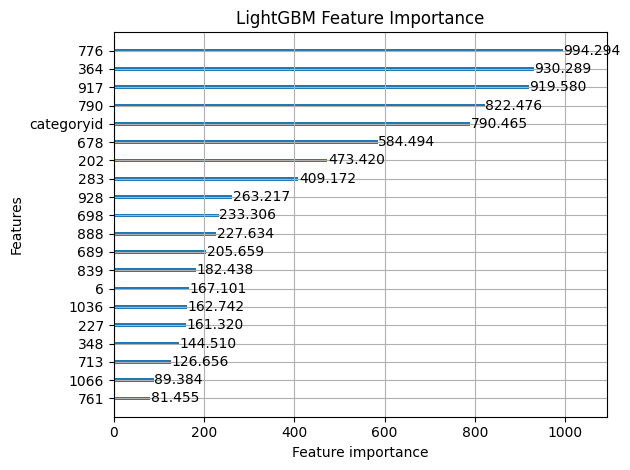

In [74]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()


# Feature Importance Analysis (CatBoost)

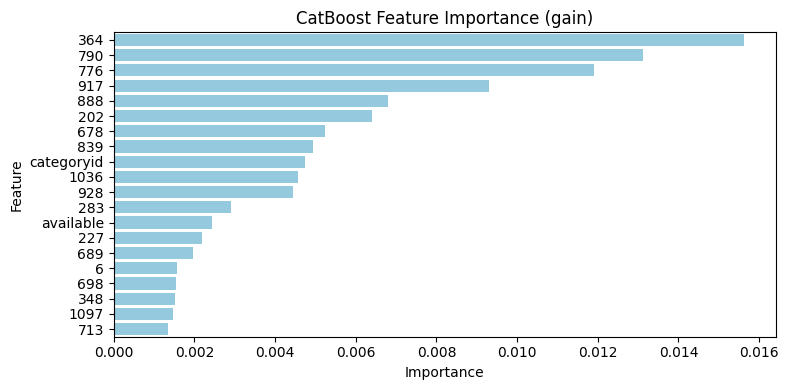

In [75]:
# Get gain-based importances for the training data
importances = cat_model.get_feature_importance(
    Pool(train_data[feature_cols],
         train_data["label"],
         group_id=train_data["session_id"]),
    type="FeatureImportance"          # default = gain
)

# Wrap into a Series for easy sorting
feat_imp = (pd.Series(importances, index=feature_cols)
            .sort_values(ascending=False)
            .head(20))                # top-20 only

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index, color="skyblue")
plt.title("CatBoost Feature Importance (gain)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Feature Importance Analysis (XGBoost)

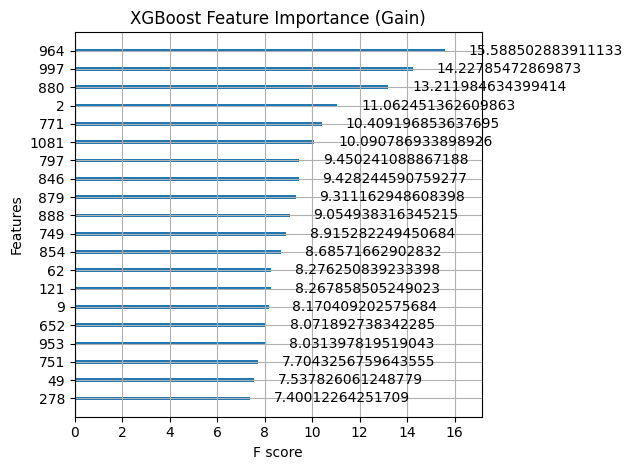

In [76]:
# Plot gain-based importance (most reliable)
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain')
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()

# Final Summary & Insights
Model	MAP@12


LightGBM -->	0.64081

CatBoost -->	0.65011

XGBoost -->	0.64153

Ensemble   = 0.64182